In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Set working directory
%cd /content/drive/My Drive/your_folder

[Errno 2] No such file or directory: '/content/drive/My Drive/your_folder'
/content


In [ ]:
# Imports
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading the data

In [ ]:
# Loading
metadata = np.loadtxt("metadata.txt", delimiter=",", skiprows=1, dtype=int)

X = np.empty((0, 627))
y_male = np.empty(0)
y_female = np.empty(0)
#y_choral = np.empty(0)
performances = np.empty(0)

num_file_pairs_to_load = 39

for idx in range(1, num_file_pairs_to_load + 1):
    samples = np.load('train%02d.npy' % idx, mmap_mode='r')
    X = np.append(X, samples, axis=0)
    performances = np.append(performances, np.full((len(samples),1), metadata[idx-1,1]))
    
    labels = np.load('train%02d.labels.npz' % idx)
    y_male = np.append(y_male, labels['male'][:, 0])
    y_female = np.append(y_female, labels['female'][:, 0])
    #y_choral = np.append(y_choral, labels['choral'][:, 0])

print("X shape:", np.shape(X))
print("y_male shape:", np.shape(y_male))
print("y_female shape:", np.shape(y_female))
#print("y_choral shape:", np.shape(y_choral))
print("performances shape:", np.shape(performances))

X shape: (297353, 627)
y_male shape: (297353,)
y_female shape: (297353,)
performances shape: (297353,)


Sample the same number of samples from each performance

In [ ]:
# sample 9505 observations in each fold
df = pd.DataFrame(X)
df["Y_female"] = y_female
df["Y_male"] = y_male
df["performance"] = performances
df_sampled = pd.DataFrame(columns=df.columns)

random.seed = 1234
n_samples_per_performance = 9505
for i in range(1,12):
  df_temp = df[df["performance"] == i].sample(n_samples_per_performance)
  df_sampled = df_sampled.append(df_temp)

# back to numpy arrays
y_female = df_sampled["Y_female"].to_numpy()
y_male = df_sampled["Y_male"].to_numpy()
df_sampled = df_sampled.drop(["Y_female", "Y_male", "performance"], axis=1)
X = df_sampled.to_numpy()

print("X shape:", np.shape(X))
print("Y_male shape:", np.shape(y_male))
print("Y_female shape:", np.shape(y_female))

X shape: (104555, 627)
Y_male shape: (104555,)
Y_female shape: (104555,)


Data Obeservation

In [ ]:
# show the Male label propotion
target = pd.DataFrame(pd.Series(y_male).value_counts(), columns=('Frequency',))
target['Percentage'] = target['Frequency'] / target['Frequency'].sum()
target.index = ['Not-Male', 'Male']
print(target)

          Frequency  Percentage
Not-Male      64402    0.615963
Male          40153    0.384037


In [ ]:
# show the Female label propotion
target = pd.DataFrame(pd.Series(y_female).value_counts(), columns=('Frequency',))
target['Percentage'] = target['Frequency'] / target['Frequency'].sum()
target.index = ['Not-Female', 'Female']
print(target)

            Frequency  Percentage
Not-Female      71699    0.685754
Female          32856    0.314246


In [ ]:
# show the each categories propotion
dict = {'Male': y_male,
        'Female': y_female,
        'Male_Female': np.zeros(len(y_female)),
        'Male_only': np.zeros(len(y_female)),
        'Female_only': np.zeros(len(y_female)),
        'Other': np.zeros(len(y_female))}
mf = pd.DataFrame(dict)
mf.loc[(mf['Male'] == 1) & (mf['Female'] == 1), 'Male_Female'] = 1
mf.loc[(mf['Male'] == 1) & (mf['Female'] == 0), 'Male_only'] = 1
mf.loc[(mf['Male'] == 0) & (mf['Female'] == 1), 'Female_only'] = 1
mf.loc[(mf['Male'] == 0) & (mf['Female'] == 0), 'Other'] = 1

freq_dict = {'Male': mf.Male.value_counts(),
             'Female': mf.Female.value_counts(),
             'Male_Female': mf.Male_Female.value_counts(),
             'Male_only': mf.Male_only.value_counts(),
             'Female_only': mf.Female_only.value_counts(),
             'Other': mf.Other.value_counts()}

target = pd.DataFrame(freq_dict)
target.index = ['Negative', 'Positive']
target

,Male,Female,Male_Female,Male_only,Female_only,Other
Negative,64402,71699,98635,70322,77619,67089
Positive,40153,32856,5920,34233,26936,37466


In [ ]:
#calculate the percentage
target = target.T
target['N-Percentage'] = target['Negative'] / (target['Negative'] + target['Positive'])
target['P-Percentage'] = target['Positive'] / (target['Negative'] + target['Positive'])
target

,Negative,Positive,N-Percentage,P-Percentage
Male,64402,40153,0.615963,0.384037
Female,71699,32856,0.685754,0.314246
Male_Female,98635,5920,0.943379,0.056621
Male_only,70322,34233,0.672584,0.327416
Female_only,77619,26936,0.742375,0.257625
Other,67089,37466,0.641662,0.358338


Data Preparation - Cost Matrix

In [ ]:
# create the cost matrix
# build a cost_mat[FP, FN, TP, TN]
cost_mat = np.zeros(104555*4).reshape((104555,4))
M_cost_mat = cost_mat.copy()
F_cost_mat = cost_mat.copy()

# compute the cost-matrix for each row: Male Classifiers
for i in range(len(y_male)):
# male with femal
  if (y_male[i]==1) & (y_female[i]==1) :
    M_cost_mat[i, 0] = 2 * (1/target['P-Percentage'][2]) #1
    M_cost_mat[i, 1] = 2 * (1/target['P-Percentage'][2])

  # male only
  if (y_male[i]==1) & (y_female[i]==0) :
    M_cost_mat[i:, 0] = 2 * (1/target['P-Percentage'][3]) #1
    M_cost_mat[i:, 1] = 2 * (1/target['P-Percentage'][3])    

  # female only
  if (y_male[i]==0) & (y_female[i]==1) :
    M_cost_mat[i, 0] = 2 * (1/target['P-Percentage'][4])
    M_cost_mat[i, 1] = 2 * (1/target['P-Percentage'][4]) #1    
  #other
  if (y_male[i]==0) & (y_female[i]==0) :
    M_cost_mat[i, 0] = 2 * (1/target['P-Percentage'][5])
    M_cost_mat[i, 1] = 2 * (1/target['P-Percentage'][5]) #1     

print("Male Cost Matrix:\n\n", M_cost_mat)


# compute the cost-matrix for each row: Female Classifiers
for i in range(len(y_female)):
# male with femal
  if (y_male[i]==1) & (y_female[i]==1) :
    F_cost_mat[i, 0] = 1
    F_cost_mat[i, 1] = 2 * (1/target['P-Percentage'][2])

  # male only
  if (y_male[i]==1) & (y_female[i]==0) :
    F_cost_mat[i:, 0] = 2 * (1/target['P-Percentage'][3])
    F_cost_mat[i:, 1] = 1    

  # female only
  if (y_male[i]==0) & (y_female[i]==1) :
    F_cost_mat[i, 0] = 1
    F_cost_mat[i, 1] = 2 * (1/target['P-Percentage'][4])    
  #other
  if (y_male[i]==0) & (y_female[i]==0) :
    F_cost_mat[i, 0] = 2 * (1/target['P-Percentage'][5])
    F_cost_mat[i, 1] = 1      

print("\n\nFemale Cost Matrix:\n\n", F_cost_mat)

Male Cost Matrix:

 [[5.58132707 5.58132707 0.         0.        ]
 [5.58132707 5.58132707 0.         0.        ]
 [6.10843338 6.10843338 0.         0.        ]
 ...
 [5.58132707 5.58132707 0.         0.        ]
 [7.76321651 7.76321651 0.         0.        ]
 [6.10843338 6.10843338 0.         0.        ]]


Female Cost Matrix:

 [[5.58132707 1.         0.         0.        ]
 [5.58132707 1.         0.         0.        ]
 [6.10843338 1.         0.         0.        ]
 ...
 [5.58132707 1.         0.         0.        ]
 [1.         7.76321651 0.         0.        ]
 [6.10843338 1.         0.         0.        ]]


Data Preparation - Train Test Split

In [ ]:
#prepare training data
#transform the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Male:take performance1(9505 records) as training data:
sets = train_test_split(X, y_male, M_cost_mat, test_size=0.9090909090909091, random_state=False, shuffle=False)
X_train, X_test, m_y_train, m_y_test, m_cost_mat_train, m_cost_mat_test = sets

# Female
f_y_train = y_female[:9505]
f_cost_mat_train = F_cost_mat[:9505]

#take part of testing data
X_test = X_test[:4074]
m_y_test = m_y_test[:4074]
m_cost_mat_test = m_cost_mat_test[:4074]
f_y_test = y_female[9505:13579]
f_cost_mat_test = F_cost_mat[9505:13579]

print("X Train:", X_train.shape)
print("Y Train(male/female):", m_y_train.shape, f_y_train.shape)
print("X Test:", X_test.shape)
print("Y Test(male/female):", m_y_test.shape, f_y_test.shape)
print("Cost Matrix(male/female):", m_cost_mat_train.shape, f_cost_mat_train.shape)
print("Test Cost Matrix(male/female):", m_cost_mat_test.shape, f_cost_mat_test.shape)

X Train: (9505, 627)
Y Train(male/female): (9505,) (9505,)
X Test: (4074, 627)
Y Test(male/female): (4074,) (4074,)
Cost Matrix(male/female): (9505, 4) (9505, 4)
Test Cost Matrix(male/female): (4074, 4) (4074, 4)


Pre-processing - Dimensional reduction

**PCA**

In [ ]:
# Calculate cumsum
pca = PCA().fit(X_train)
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Find the best number of components
CUMSUM_THR = 0.95
num_components = 0
i = 0
while i < len(cum_sum):
    if cum_sum[i] > CUMSUM_THR:
        print("Best num_components = " + str(i) + "   variance: " + str(cum_sum[i]))
        num_components = i
        break
    i += 1

if (num_components == 0): print("Best num_components not found")

Best num_components = 161   variance: 0.9504727922270872


**LDA**

In [ ]:
# Create a function to select the best component
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components


###Function for finding the best component and build LDA

def select_lda(X_train, Y_train):

  # Create an LDA
  lda = LinearDiscriminantAnalysis()

  # run an LDA and use it to transform the features
  X_lda = lda.fit(X_train, Y_train).transform(X_train)

  # Print the number of features
  print('Original number of features:', X_train.shape[1])
  print('Reduced number of features:', X_lda.shape[1])

  # View the ratio of explained variance
  print(lda.explained_variance_ratio_)
  # show the bwst component number
  select_C = select_n_components(lda.explained_variance_ratio_, 0.95)
  print(select_C)

In [ ]:
#Male
select_lda(X_train, m_y_train)
#Female
select_lda(X_train, f_y_train)

Original number of features: 627
Reduced number of features: 1
[1.]
1
Original number of features: 627
Reduced number of features: 1
[1.]
1


In [ ]:
# Apply preprocessing
# Perform PCA
pca = PCA(n_components=159)
X_PCA_train = pca.fit(X_train).transform(X_train)
print("PCA_train shape:", np.shape(X_PCA_train))

# perform LDA
# Male
lda = LinearDiscriminantAnalysis(n_components=1)
mX_LDA_train = lda.fit(X_train, m_y_train).transform(X_train)
print("LDA_train shape:", np.shape(mX_LDA_train))

# Female
fX_LDA_train = lda.fit(X_train, f_y_train).transform(X_train)
print("LDA_train shape:", np.shape(fX_LDA_train))

PCA_train shape: (9505, 159)
LDA_train shape: (9505, 1)
LDA_train shape: (9505, 1)


In [ ]:
# Apply preprocessing to testing data

# PCA
X_PCA_test = pca.fit(X_train).transform(X_test)
print("PCA_test shape:", np.shape(X_PCA_test))

# LDA
# Male
mX_LDA_test = lda.fit(X_train, m_y_train).transform(X_test)
print("LDA_test shape:", np.shape(mX_LDA_test))

# Female
fX_LDA_test = lda.fit(X_train, f_y_train).transform(X_test)
print("LDA_test shape:", np.shape(fX_LDA_test))

PCA_test shape: (4074, 159)
LDA_test shape: (4074, 1)
LDA_test shape: (4074, 1)


Cost-Sensitive Learning Classifiers

In [ ]:
#install costla package
!pip install costcla

     |████████████████████████████████| 4.0MB 4.6MB/s 
  Created wheel for pyea: filename=pyea-0.2-cp36-none-any.whl size=6017 sha256=a5e09aa849175a585f9ea86ceb6fb40ae10b891953003f881433779fc3464a1d
  Stored in directory: /root/.cache/pip/wheels/3c/bf/6e/06f8b0ed23cbc1fe956f8b6756535cb36f0b68c2f0f2342178
Successfully built pyea


Define Functions

In [ ]:
# set the pipelines


In [ ]:
#Import libaries
from costcla.metrics import savings_score, cost_loss
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#Load cost-sensitive classifiers
from costcla.models import CostSensitiveLogisticRegression
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.models import CostSensitiveRandomForestClassifier


def compare_classifiers(X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test):
  # Fit the classifiers using the training dataset
  classifiers = {"RF": {"f": RandomForestClassifier()},
                "DT": {"f": DecisionTreeClassifier()},
                "LR": {"f": LogisticRegression()}}


  #Prediction for non-cost-sensitive classifier
  for model in classifiers.keys():
      #Fit
      classifiers[model]["f"].fit(X_train, y_train)
      # Predict
      classifiers[model]["c"] = classifiers[model]["f"].predict(X_test)
      classifiers[model]["p"] = classifiers[model]["f"].predict_proba(X_test)
      classifiers[model]["p_train"] = classifiers[model]["f"].predict_proba(X_train)
       

  # Evaluate the performance
  measures = {"f1": f1_score, "pre": precision_score, 
              "rec": recall_score, "acc": accuracy_score}
  global results            
  results = pd.DataFrame(columns=measures.keys())

  # Evaluate each model in classifiers
  for model in classifiers.keys():
      results.loc[model] = [measures[measure](y_test, classifiers[model]["c"]) for measure in measures.keys()]
 

  # Evaluate the savings for each model
  results["sav"] = np.zeros(results.shape[0])
  for model in classifiers.keys():
      results["sav"].loc[model] = savings_score(y_test, classifiers[model]["c"], cost_mat_test)    

  #Build cost-sensitive classifiers
  classifiers["CS-RF"] = {"f": CostSensitiveRandomForestClassifier()}
  classifiers["CS-DT"] = {"f": CostSensitiveDecisionTreeClassifier()}
  classifiers["CS-LR"] = {"f": CostSensitiveLogisticRegression()}

  for model in list(classifiers)[3:6]:
    # Fit
    classifiers[model]["f"].fit(X_train, y_train, cost_mat_train)
    # Predict
    classifiers[model]["c"] = classifiers[model]["f"].predict(X_test)
    # Evaluate
    results.loc[model] = 0
    results.loc[model, measures.keys()] = \
    [measures[measure](y_test, classifiers[model]["c"]) for measure in measures.keys()]
    results["sav"].loc[model] = savings_score(y_test, classifiers[model]["c"], cost_mat_test)

  return results


#plotting functions
def plot_performance(result):
  figsize(10, 5)
  ax = plt.subplot(111)

  ind = np.arange(result.shape[0])
  width = 0.2
  l = ax.plot(ind, results, "-o")
  plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
  ax.set_xlim([-0.25, ind[-1]+.25])
  ax.set_xticks(ind)
  ax.set_xticklabels(results.index)
  plt.show()  


def plot_comparison(results):
  colors = sns.color_palette()
  
  ind = np.arange(results.shape[0])
  figsize(10, 5)
  ax = plt.subplot(111)
  l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
  b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  ax.set_xlim([-0.5, ind[-1]+.5])
  ax.set_xticks(ind)
  ax.set_xticklabels(results.index)
  plt.show()  

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

In [ ]:
#Male classifiers performances with PCA
compare_classifiers(X_PCA_train, X_PCA_test, m_y_train, m_y_test, m_cost_mat_train, m_cost_mat_test)
male_result = results

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/costcla/models/regression.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
male_result

,f1,pre,rec,acc,sav
RF,0.800922,0.881557,0.733803,0.872852,0.417394
DT,0.678969,0.671488,0.686620,0.773687,0.295595
LR,0.807444,0.876340,0.748592,0.875552,0.419576
CS-RF,0.708223,0.669173,0.752113,0.783996,0.466492
CS-DT,0.742953,0.709615,0.779577,0.811978,0.474532
CS-LR,0.308464,0.293818,0.324648,0.492636,-0.441752


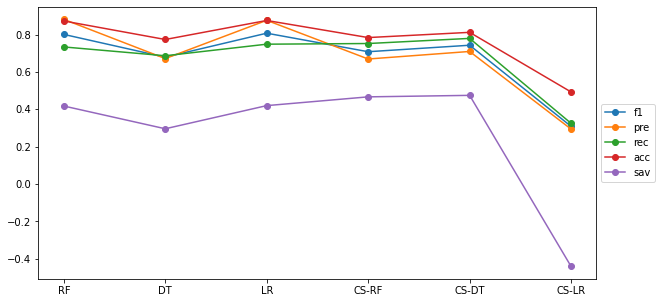

In [ ]:
plot_performance(male_result)

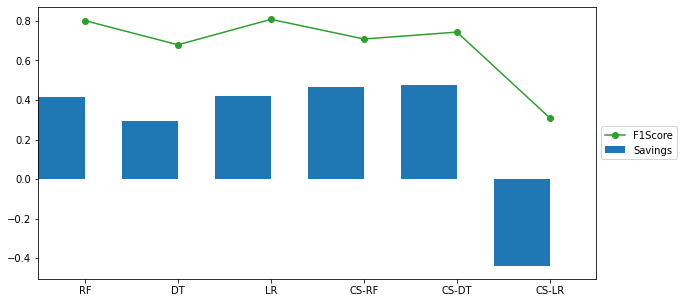

In [ ]:
plot_comparison(male_result)

In [ ]:
#Male classifiers performances with LDA
compare_classifiers(mX_LDA_train, mX_LDA_test, m_y_train, m_y_test, m_cost_mat_train, m_cost_mat_test)
lda_male_result = results

In [ ]:
###2
#Male classifiers performances with LDA
compare_classifiers(mX_LDA_train, mX_LDA_test, m_y_train, m_y_test, m_cost_mat_train, m_cost_mat_test)
lda_male_result = results

In [ ]:
lda_male_result

,f1,pre,rec,acc,sav
RF,0.803779,0.830330,0.778873,0.867452,0.489308
DT,0.803344,0.830203,0.778169,0.867207,0.487325
LR,0.839700,0.896800,0.789437,0.894944,0.516649
CS-RF,0.867147,0.845948,0.889437,0.905007,0.671977
CS-DT,0.868631,0.855290,0.882394,0.906971,0.664042
CS-LR,0.516928,0.348552,1.000000,0.348552,0.000000


In [ ]:
###2
lda_male_result

,f1,pre,rec,acc,sav
RF,0.781978,0.823151,0.744727,0.859843,0.424036
DT,0.781978,0.823151,0.744727,0.859843,0.424036
LR,0.824128,0.893039,0.765091,0.889789,0.465967
CS-RF,0.847882,0.858955,0.837091,0.898625,0.585759
CS-DT,0.846522,0.856930,0.836364,0.897644,0.584258
CS-LR,0.504680,0.337506,1.000000,0.337506,0.000000


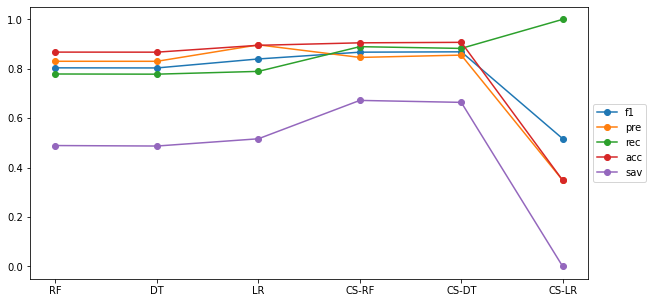

In [ ]:
plot_performance(lda_male_result)

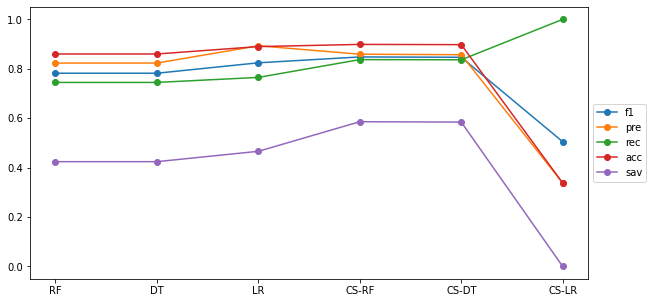

In [ ]:
### 2
plot_performance(lda_male_result)

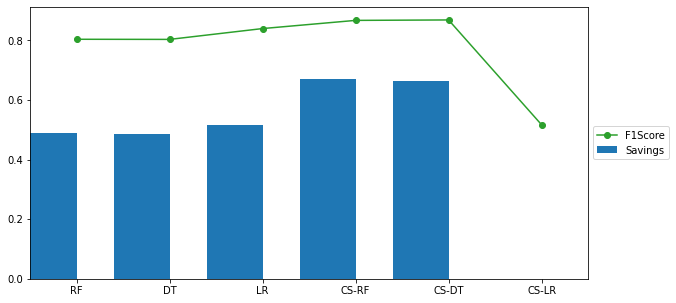

In [ ]:
plot_comparison(lda_male_result)

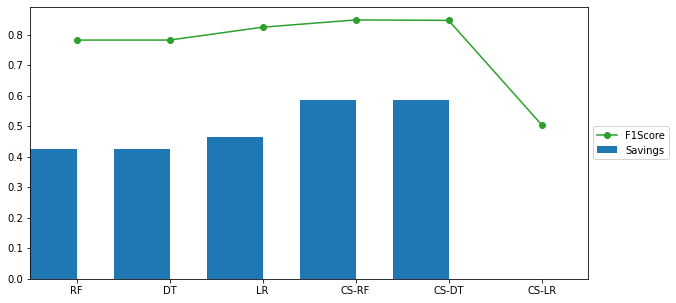

In [ ]:
### 2
plot_comparison(lda_male_result)

In [ ]:
#Female classifiers performances with PCA
compare_classifiers(X_PCA_train, X_PCA_test, f_y_train, f_y_test, f_cost_mat_train, f_cost_mat_test)
female_result = results
print(female_result)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/costcla/models/regression.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


             f1       pre       rec       acc       sav
RF     0.747345  0.961889  0.611053  0.807315 -0.441152
DT     0.702654  0.810736  0.620000  0.755277 -0.317361
LR     0.783958  0.883245  0.704737  0.818851 -0.220776
CS-RF  0.631839  0.959271  0.471053  0.743986 -0.629454
CS-DT  0.685400  0.816594  0.590526  0.747177 -0.295429
CS-LR  0.199513  0.434629  0.129474  0.515464 -0.919612


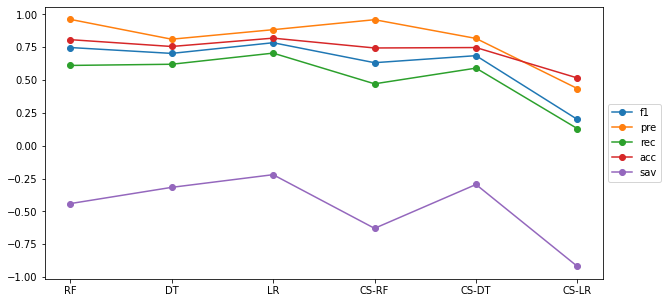

In [ ]:
plot_performance(female_result)

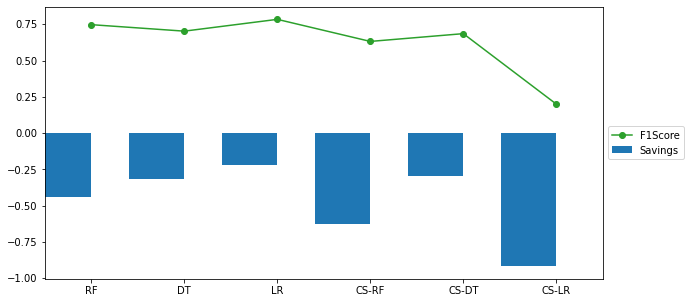

In [ ]:
plot_comparison(female_result)

In [ ]:
# Female classifiers performances with LDA
compare_classifiers(fX_LDA_train, fX_LDA_test, m_y_train, m_y_test, m_cost_mat_train, m_cost_mat_test)
lda_female_result = results

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lda_female_result

,f1,pre,rec,acc,sav
RF,0.466542,0.419573,0.525352,0.581247,-0.051197
DT,0.466688,0.419809,0.525352,0.581492,-0.050883
LR,0.410218,0.439614,0.384507,0.614629,-0.249186
CS-RF,0.601050,0.435914,0.967606,0.552283,0.299926
CS-DT,0.606195,0.441935,0.964789,0.563083,0.314258
CS-LR,0.000000,0.000000,0.000000,0.651448,-0.333454


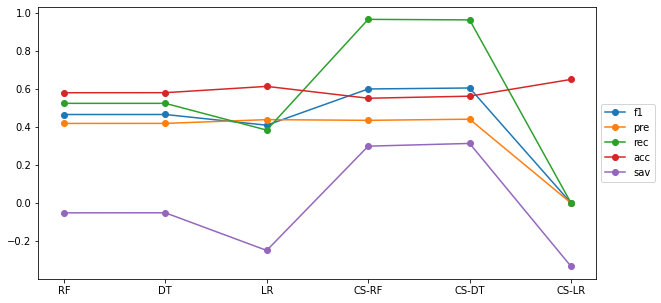

In [ ]:
plot_performance(lda_female_result)

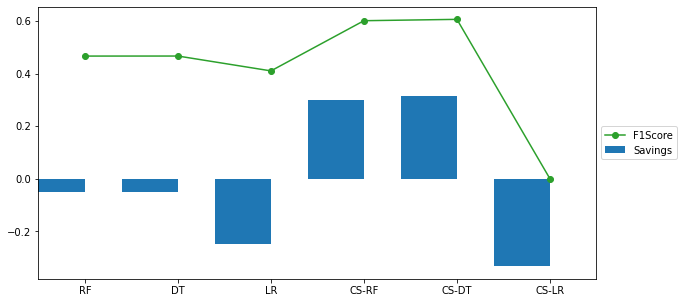

In [ ]:
plot_comparison(lda_female_result)